In [1]:
# load libraries
library(rvest)
library(ggplot2)
library(FinCal)

Loading required package: xml2
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'FinCal' was built under R version 3.6.3"

In [2]:
# Get stock of choice from user
stock <- readline(prompt="Enter stock ticker: ")

Enter stock ticker: AXP


In [3]:
# Get html of all important pages for webscraping
income_statement <- paste0('https://www.marketwatch.com/investing/stock/',stock,'/financials')
income_statement_page <- income_statement %>% read_html()
balance_sheet <- paste0('https://www.marketwatch.com/investing/stock/',stock,'/financials/balance-sheet')
balance_sheet_page <- balance_sheet %>% read_html()
cash_flow <- paste0('https://www.marketwatch.com/investing/stock/',stock,'/financials/cash-flow')
cash_flow_page <- cash_flow %>% read_html()
key_metrics <- paste0('https://www.marketwatch.com/investing/stock/',stock)
more_stats <- paste0("https://finviz.com/quote.ashx?t=",stock)
more_stats_page <- more_stats %>% read_html()

# Get names of each column (i.e. revenue) and associated numeric values for each page
income_names <- income_statement_page %>% html_nodes(".overflow__cell .fixed--cell") %>% html_text()
income_nums <- income_statement_page %>% html_nodes(".cell__content span") %>% html_text()
balance_names <- balance_sheet_page %>% html_nodes(".overflow__cell .fixed--cell") %>% html_text()
balance_nums <- balance_sheet_page %>% html_nodes(".cell__content span") %>% html_text()
cash_names <- cash_flow_page %>% html_nodes(".overflow__cell .fixed--cell") %>% html_text()
cash_nums <- cash_flow_page %>% html_nodes(".cell__content span") %>% html_text()
stats_names <- more_stats_page %>% html_nodes(".snapshot-td2-cp") %>% html_text()
stats_nums <- more_stats_page %>% html_nodes(".snapshot-td2 b") %>% html_text()

In [4]:
# function to convert scraped data from strings into numeric values. Accounts for whether value is in billions/millions and 
# if it should be negative
convert <- function(x) {
  x <- gsub('[(]',"-",x)
  x <- gsub('[)]',"",x)
  if (grepl("B", x)) {
    x <- gsub('[B]',"",x) 
    x <- as.numeric(x)
    x*1000
  } else if (grepl("M", x)) {
    x <- gsub('[M]',"",x)
    x <- as.numeric(x) 
    x*1
  } else if (grepl("-", x)) {
    x <- gsub('-',"0",x)
    x <- as.numeric(x)
  }
}

In [5]:
# looping through names to find each necessary data column and associated numeric value(s)
x<-1
while (income_names[x] != "Sales/Revenue") {x<-x+1}
Revenue <- income_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Revenue[i] <- convert(Revenue[i])
}
Revenue <- as.numeric(Revenue)
x<-1
while (income_names[x] != "Net Income") {x<-x+1}
Net_Income <- income_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Net_Income[i] <- convert(Net_Income[i])
}
Net_Income <- as.numeric(Net_Income) 
x<-1
while (balance_names[x] != "Total Equity") {x<-x+1}
Equity <- balance_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Equity[i] <- convert(Equity[i])
}
Equity <- as.numeric(Equity)
x<-1
while (balance_names[x] != "ST Debt & Current Portion LT Debt") {x<-x+1}
Debt <- balance_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Debt[i] <- convert(Debt[i])
}
Debt <- as.numeric(Debt)
x<-1
while (cash_names[x] != "Net Operating Cash Flow") {x<-x+1}
Operating_Cash <- cash_nums[(5*(x-1)+1):(5*x)]
for(i in 1:5){
  Operating_Cash[i] <- convert(Operating_Cash[i])
}
Operating_Cash <- as.numeric(Operating_Cash)

#Calculating ROIC and ROE
ROIC <- c()
for(i in 1:5) {
  x <- Net_Income[i]/(Equity[i] + Debt[i]) 
  ROIC <- append(ROIC,round(x,2))
}
ROE <- c()
for(i in 1:5) {
  x <- Net_Income[i]/Equity[i]
  ROE <- append(ROE,round(x,2))
}

# Storing all important financial data in df
df <- data.frame (
  year = 1:5,
  Revenue = Revenue,
  Net_Income = Net_Income, 
  Debt = Debt ,
  Equity = Equity,
  Operating_Cash = Operating_Cash,
  ROIC = ROIC,
  ROE = ROE
)

## Financial Data Visualization (last 5 years) ##

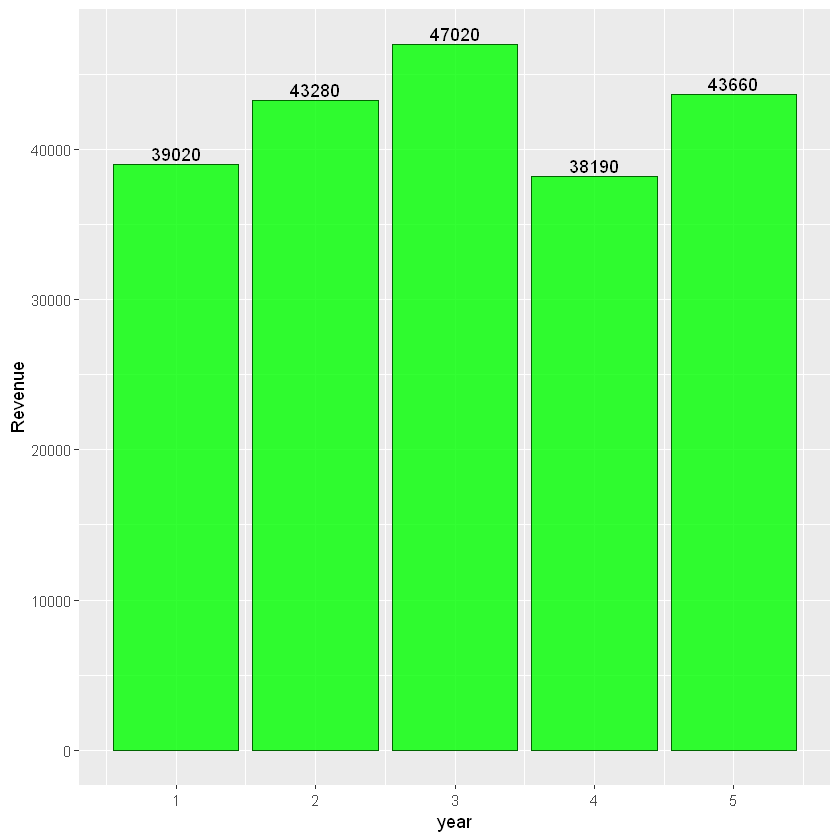

In [6]:
# year 5 is most recent data
ggplot(df, aes(year,Revenue)) +
  geom_bar(stat="identity", fill = "green", color = "darkgreen", alpha = 0.8) +
  geom_text(aes(label=Revenue), vjust = -0.3)

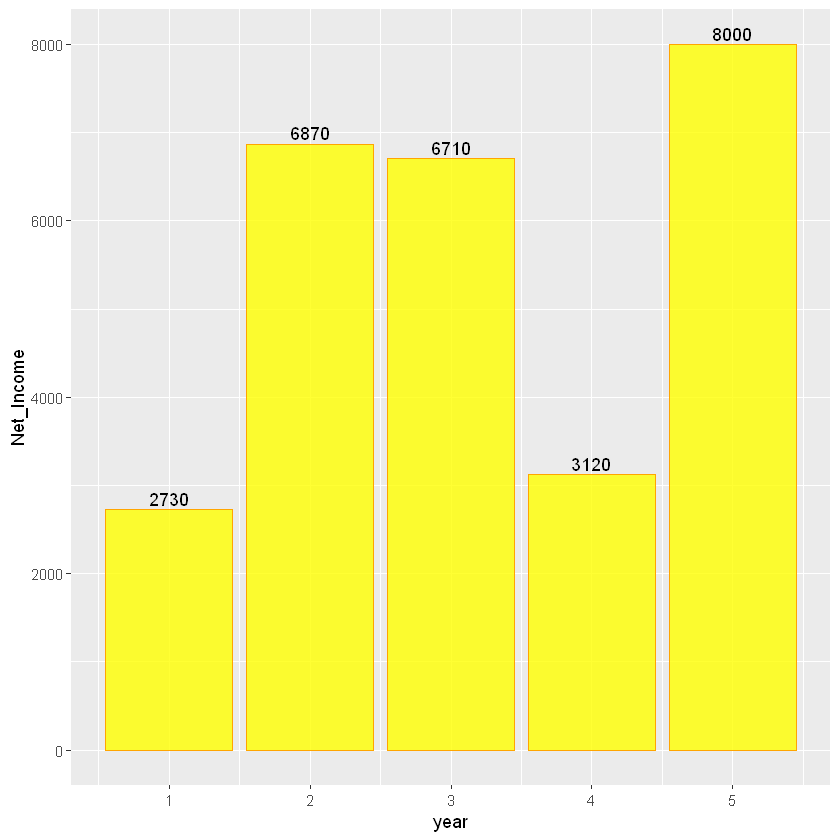

In [7]:
ggplot(df, aes(year,Net_Income)) +
  geom_bar(stat="identity", fill = "yellow", color = "orange", alpha = 0.8) +
  geom_text(aes(label=Net_Income), vjust = -0.3)

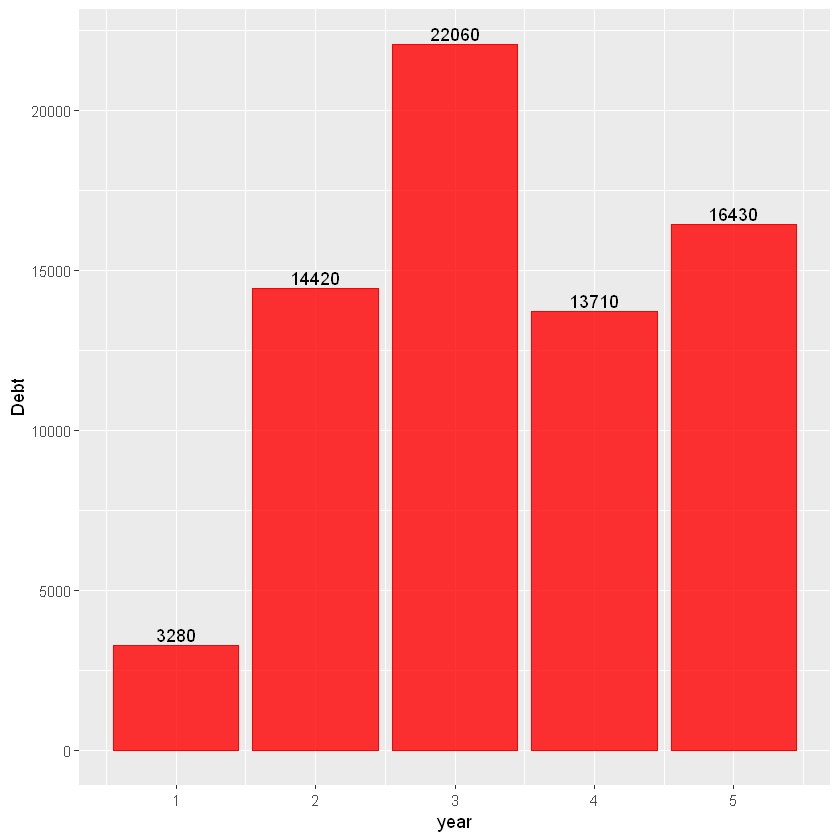

In [8]:
ggplot(df, aes(year,Debt)) +
  geom_bar(stat="identity", fill = "red", color = "red", alpha = 0.8) +
  geom_text(aes(label=Debt), vjust = -0.3)

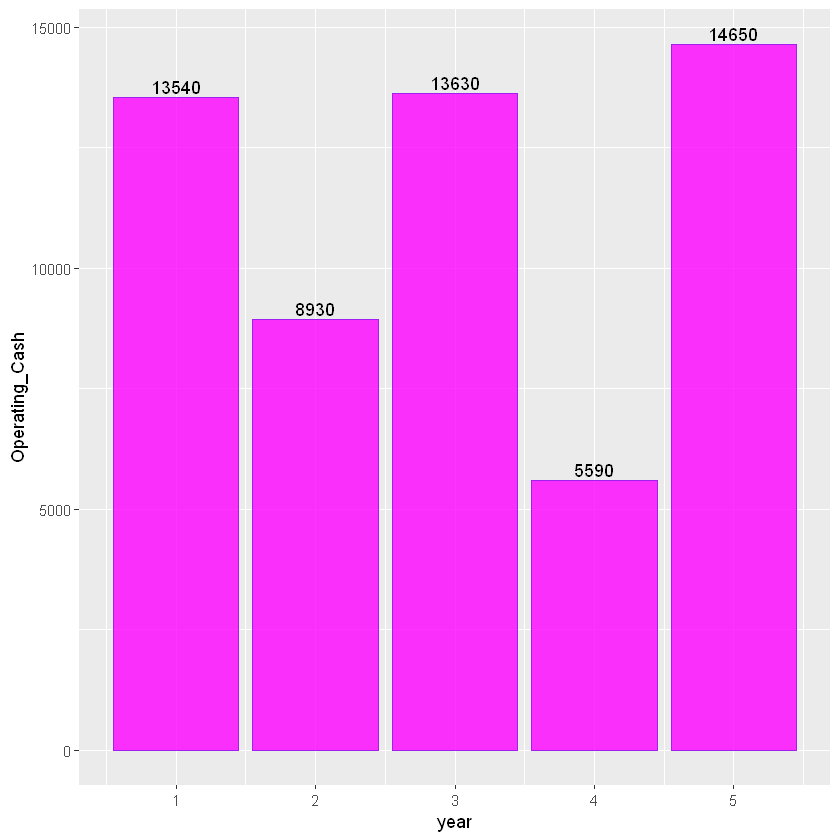

In [9]:
ggplot(df, aes(year,Operating_Cash)) +
  geom_bar(stat="identity", fill = "magenta", color = "purple", alpha = 0.8) +
  geom_text(aes(label=Operating_Cash), vjust = -0.3)

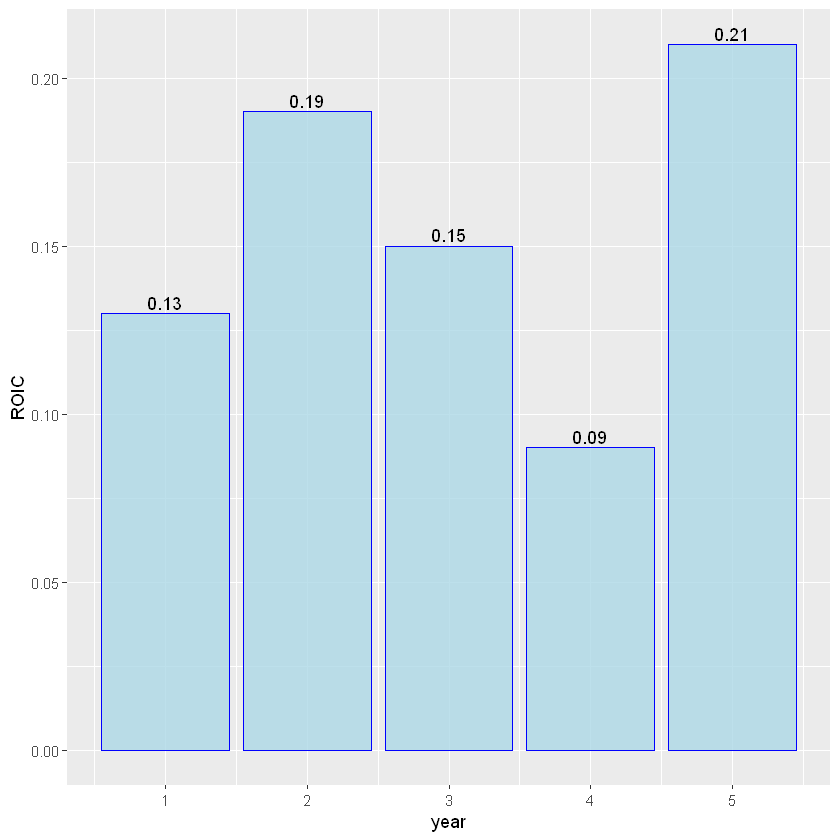

In [10]:
ggplot(df, aes(year,ROIC)) +
  geom_bar(stat="identity", fill = "lightblue", color = "blue", alpha = 0.8) +
  geom_text(aes(label=ROIC), vjust = -0.3)


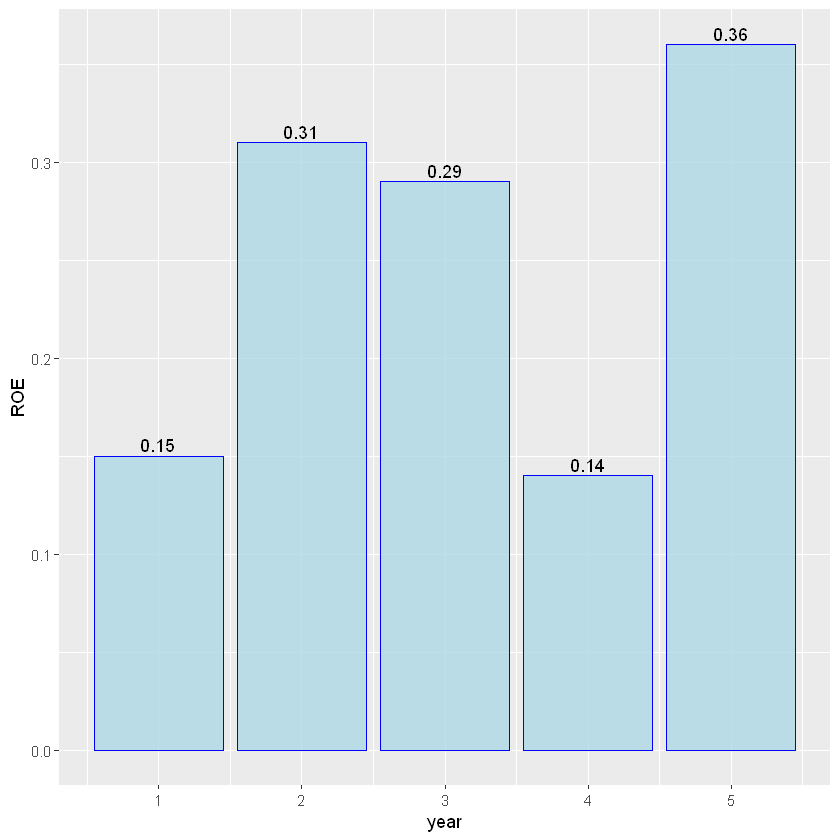

In [11]:
ggplot(df, aes(year,ROE)) +
  geom_bar(stat="identity", fill = "lightblue", color = "blue", alpha = 0.8) +
  geom_text(aes(label=ROE), vjust = -0.3)

### Valuation ###

In [12]:
# Getting necessary data for Valuation
x<-1
while (income_names[x] != "EPS (Basic)") {x<-x+1}
EPS <- income_nums[(5*x)] %>% as.double()
x<-1
while (stats_names[x] != "P/E") {x<-x+1}
PE <- stats_nums[x] %>% as.double()
x<-1
while (stats_names[x] != "Price") {x<-x+1}
price <- stats_nums[x] %>% as.double()
x<-1
while (stats_names[x] != "Shs Outstand") {x<-x+1}
shares <- stats_nums[x] %>% convert()
x<-1
while (cash_names[x] != "Free Cash Flow") {x<-x+1}
FCF <- cash_nums[(5*x)]
FCF <- convert(FCF)
FCF <- as.numeric(FCF)/shares

# Method 1 for calculating buy prices
a <- FCF
for (i in 1:8) {
  a[i+1] <- a[i]+a[i]*.1
}
BuyPrice1 <- sum(a)-a[1]
# Method 2 for calculating buy prices
proj_growth <- as.numeric(readline(prompt = "Enter projected growth: "))
Future_Value <- fv(proj_growth,10, -EPS)*PE
Present_Value <- pv(.15,10,-Future_Value)
BuyPrice2 <- Present_Value/2
cat("Stock: ", stock," Current Price: ", price," Buy Prices: ",round(BuyPrice1,2),";",round(BuyPrice2,2),".",sep="")


Enter projected growth: .12
Stock: AXP Current Price: 149.26 Buy Prices: 218.8;58.21.